# Titanic - Predicting Passengers chances to survive

## Work in progress

**Next steps :** 
- ***Tackle the problem section (DONE)***
- ***Tackle the EDA section (DONE)***
- ***Tackle the Modeling section + understand how the sklearn functions work (monday)***
- Make new submission (monday)
- Tackle challenges (after holidays ~ start w/ 3 first ones + left ones after holidays)

**Challenges :** 
- 1) How would you fill the missing variables in the Age column? (and then add it to our model inputs)
- 2) How could you reduce the Ticket feature? Is it even possible? (and then add it to our model inputs)
- 3) How would you change the Fare bins? 
- 4) What are some ways to visualise precision and recall?
- 5) Feature Reduction / Selection techincs : How can we use PCA to reduce the number of inputs of the model (dimensionnality reduction)? How can we filter only the most relevant features (feature correlation)?

# Problem statement

In this competition, our goal is to create a model that predicts which passengers survived the Titanic shipwreck.

Before diving into the data, let's get more context about the history behind the sinking of the Titanic. Understanding the chain of events will allow us to better consider the relative importance of the features we have at hand in our dataset.

Based on the [Wikipedia page](https://fr.wikipedia.org/wiki/Naufrage_du_Titanic#:~:text=Le%20navire%20heurte%20un%20iceberg,plus%20meurtri%C3%A8re%20pour%20l'%C3%A9poque.) about the Sinking of the Titanic, we have 3 key information related to features of our dataset :

- During the evacuation of the boat, **child and females** had priority access to the lifeboats ;
- As the collision took place at the front of the boat, the **1st classes** were among the first passengers to be alerted and equipped, as their cabins were located nearby. They also had an advantage in obtaining a place in these first boats, given the proximity of their cabin to the boat deck ;
- Passengers who embarked in **Cherbourg were mainly from the first class**, while the vast majority of Irish people boarding in **Queenstone were 3rd class passengers** immigrating to the US.

Based on these information, we can guess that the following data points will be important to predict passengers' likeliness to survive : **Age, Sex, PClass**.

# Exploratory Data Analysis

## Import packages

First we will import all the relevant dependencies we need.

In [339]:
# Data manipulation
import pandas as pd
import numpy as np

# Start Python Imports
import math, time, random, datetime

# Visualisation
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder

# Machine learning
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Ignore warnings 
import warnings
warnings.filterwarnings('ignore')

## Loading in the data

I have downloaded the data from the [Titanic competition space on Kaggle](https://www.kaggle.com/c/titanic/data).

To make our predictions, we have 3 different datasets : 
- train.csv : this the dataset we will use to build our model ; 
- test.csv : we will use this dataset to see how well your model performs on unseen data ;
- gender_submission.csv : this file is here to give us an example of how the submission file should look like.

In [5]:
training_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
submission_example_data = pd.read_csv('data/gender_submission.csv')

In [4]:
# View the training data 
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# View the test data
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
# View the example submission data
submission_example_data.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## Data Descriptions

**Survival:** 0 = No, 1 = Yes

**pclass (Ticket class):** 1 = 1st, 2 = 2nd, 3 = 3rd

**sex:** Sex

**Age:** Age in years

**sibsp:** number of siblings/spouses aboard the Titanic

**parch:** number of parents/children aboard the Titanic

**ticket:** Ticket number

**fare:** Passenger fare

**cabin:** Cabin number

**embarked:** Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [8]:
training_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Missing values identification

From the table above, we can observe that some columns have less values than others. 

Let's understand where are the holes in our data and how it might impact the usability of features.

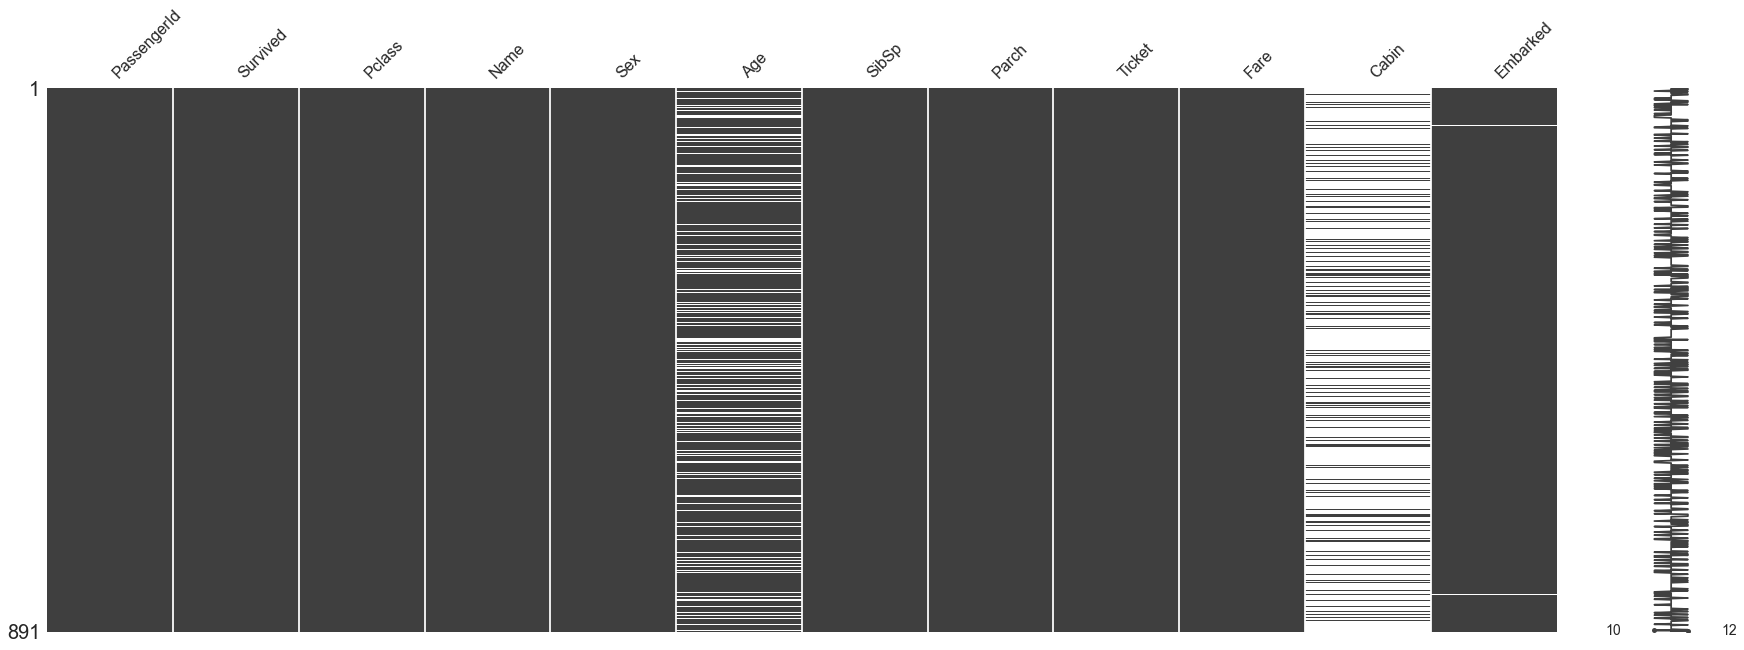

In [15]:
# Plot graphic of missing values
missingno.matrix(training_data, figsize = (30,10))

In [51]:
# function that shows the number of missing values per field
def count_missing_values(df): 
    """
    Count the number of missing values in each columns of the dataframe
        Parameters:
            table : dataframe that we want to scan to identify missing values
        Return:
            missing_vals (dict) : dictionnary listing the number of missing values per column
    
    """
    print('Number of missing or NaN value for each column:')
    keys = []
    values = []
    
    for element in df.columns:
        keys.append(element)
        values.append(str(df[element].isnull().sum()) + ' (' + str(round(df[element].isnull().sum()/len(df)*100, 2)) + '%)')
    
    missing_vals = {keys[i]: values[i] for i in range(len(keys))}
    
    return missing_vals

In [150]:
missing_vals = count_missing_values(training_data)
missing_vals

Number of missing or NaN value for each column:


{'PassengerId': '0 (0.0%)',
 'Survived': '0 (0.0%)',
 'Pclass': '0 (0.0%)',
 'Name': '0 (0.0%)',
 'Sex': '0 (0.0%)',
 'Age': '177 (19.87%)',
 'SibSp': '0 (0.0%)',
 'Parch': '0 (0.0%)',
 'Ticket': '0 (0.0%)',
 'Fare': '0 (0.0%)',
 'Cabin': '687 (77.1%)',
 'Embarked': '2 (0.22%)'}

We can clearly observe that 3 columns are missing data : 
- **Age:** about 20% of values are missing, we will need to do some manipulations before moving to the modeling step ;
- **Cabin:** 77% of data is missing. It is going to be complicated to take advantage of this field considering the number of missing values ; 
- **Embarked:** there are only 2 missing values which is negligeable. We will have to decide what we do with the rows that are impacted.

## Dataframe datatypes

Generally, when we observe features with an "object" data type they can be considered as categorical. The ones which are floats or ints are numerical features.

It can happen that some numerical fields may actually be categorical.

Ideally, we should process the data in a way that all the features will be encoded into a numerical value.

In [55]:
training_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Feature Exploration

Before diving into each feature individually, we will create two separate dataframes for the exploration phase : one for continuous variables and the other for discrete ones. We don't want to modify our training dataset as it is our source of truth.

In [57]:
df_con = pd.DataFrame() # for continuous variables
df_dis = pd.DataFrame() # for discretised continuous variables

For each feature, we will plot their distribution to understand what kind of spread there is across the dataset. 

We want to be able to exclude values which are completely off the distribution (outliers) as well as get an overview of the number of people who survived per unique value.

In [228]:
def plot_count_dist(data, dis_df, label_column, target_column, figsize=(20, 5), use_dis_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
        Parameters
            data: target dataframe
            dis_df: discrete dataframe for countplot
            label_column: binary labelled column
            target_column: column you want to view counts and distributions
            figsize: size of figure (width, height)
            param_use_bin_df: whether or not to use the bin_df, default False
        Return
            count_plot: bar graph of the count of unique values
            distplot: distribution of the number of passenger who survived per unique value
            
    """
    if use_dis_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=dis_df);
        plt.subplot(1, 2, 2)
        sns.distplot(df_dis.loc[df_dis[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived", 'bw' : 0.1});
        sns.distplot(df_dis.loc[df_dis[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive", 'bw' : 0.1});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived", 'bw' : 0.1});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive", 'bw' : 0.1});

### Target Feature: Survived

Description: Whether the passenger survived or not.

Key: 0 = did not survive, 1 = survived

Survive is our target feature. It is the one that we want to predict with our Machine Learning model based off all the others.

0    549
1    342
Name: Survived, dtype: int64


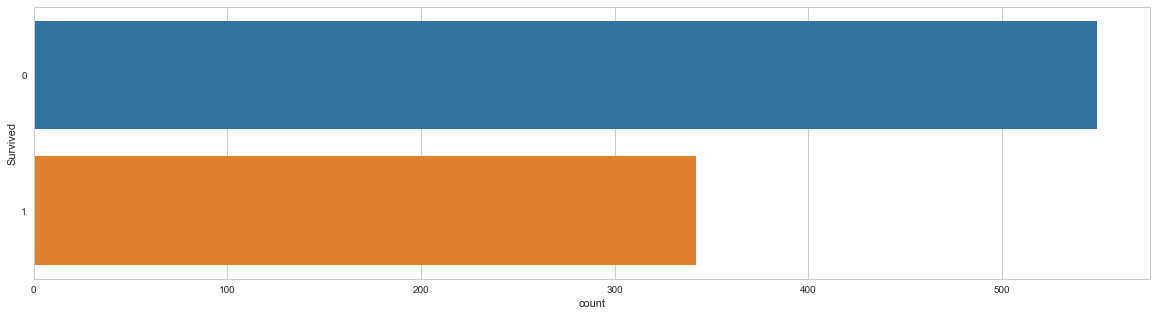

In [141]:
fig = plt.figure(figsize=(20,5))
sns.countplot(y='Survived', data=training_data);
print(training_data.Survived.value_counts())

As there is no missing values in our training dataset in this column. No transformation is required in this field, we can add it to both our subset dataframes.

In [69]:
df_con['Survived'] = training_data['Survived']
df_dis['Survived'] = training_data['Survived']

### Feature: Pclass

Description: The class in which the passenger travels.

Key: 1 = 1st class ; 2 = 2nd class ; 3 = 3rd class.

In [119]:
training_data.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [121]:
training_data.Pclass.isnull().sum()

0

As expected, we can observe that there are only 3 different numerical values available in the field. We also know that there are no missing values. Thus, no transformation is required in this field, we can add it to both our discrete subset dataframe.

In [92]:
df_dis['Pclass'] = training_data['Pclass']
df_con['Pclass'] = training_data['Pclass']

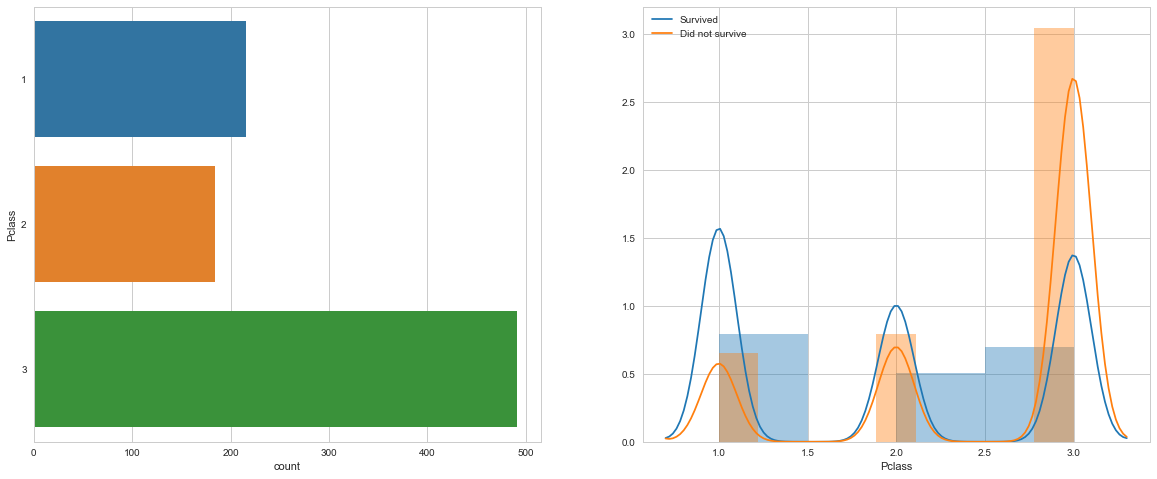

In [136]:
plot_count_dist(data= training_data , 
                dis_df= df_dis, 
                label_column= 'Survived', 
                target_column= 'Pclass', 
                figsize=(20, 8))

### Feature: Name

Description: The name of the passengers.

In [79]:
training_data.Name.value_counts()

Palsson, Miss. Stina Viola                 1
Sagesser, Mlle. Emma                       1
Meyer, Mrs. Edgar Joseph (Leila Saks)      1
Milling, Mr. Jacob Christian               1
Hart, Mr. Benjamin                         1
                                          ..
Cleaver, Miss. Alice                       1
Taylor, Mr. Elmer Zebley                   1
Moen, Mr. Sigurd Hansen                    1
O'Connell, Mr. Patrick D                   1
Touma, Mrs. Darwis (Hanne Youssef Razi)    1
Name: Name, Length: 891, dtype: int64

In [122]:
training_data.Name.isnull().sum()

0

Here we can observe that every passenger has a unique name. In the first step of this exploration, because there are so many unique values, we won't move forward using the name variable for our predictions.

### Feature: Sex

Description: Sex of the passengers.

Keys : male or female.

In [123]:
training_data.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [124]:
training_data.Sex.isnull().sum()

0

There is not any missing value nor outliers in this field, so we can add it to our subset dataframes. 

We will just make a transformation to the datatype of Sex after adding it to our discrete dataframe so that we can compare the Sex variable with Survival (we can only make the comparison if both datatypes are numerical).

In [125]:
df_dis['Sex'] = training_data['Sex']
df_dis['Sex'] = np.where(df_dis['Sex'] == 'female', 1, 0) # change sex to 0 for male and 1 for female

df_con['Sex'] = training_data['Sex']

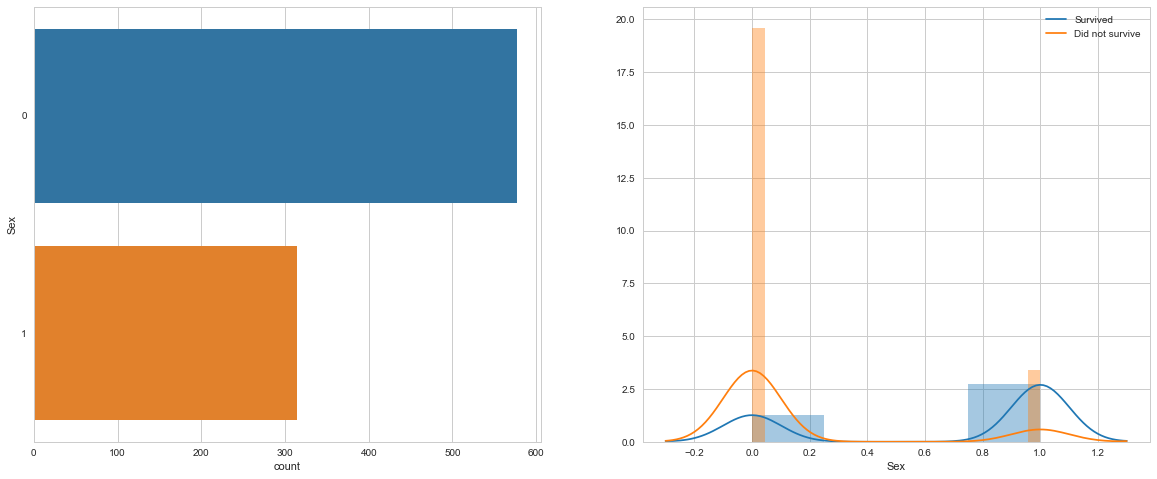

In [143]:
plot_count_dist(data= training_data , 
                dis_df= df_dis, 
                label_column= 'Survived', 
                target_column= 'Sex', 
                figsize=(20, 8),
                use_dis_df=True)

Overall, whatever their Sex, most passengers did not Survive. However, among those who did more were females

### Feature: Age

Description: Age of the passengers.

In [144]:
training_data.Age.value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64

In [176]:
print("There are {} unique Age values.".format(len(training_data.Age.unique())))

There are 89 unique Age values.


In [145]:
training_data.Age.isnull().sum()

177

In [177]:
print("There are {} missing Age values.".format(missing_vals['Age']))

There are 177 (19.87%) missing Age values.


Out of a total 891 rows, there are 177 missing values. That's almost one fifth of the dataset.

In this initial step of EDA, we won't add the column to our subset dataframes as it needs further manipulations. We need to decide what to do with missing values.

**Challenge #1 :** How would you fill the missing variables in the Age column?

### Feature: SibSp

Description: The number of siblings/spouses the passenger has aboard the Titanic.

In [152]:
training_data.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [154]:
training_data.SibSp.isnull().sum()

0

There are no missing values in the column. We can also see that there is a limited number of unique values. There is no outlier neither. 

We can add this field to our subset dataframes.

In [155]:
df_con['SibSp'] = training_data['SibSp']
df_dis['SibSp'] = training_data['SibSp']

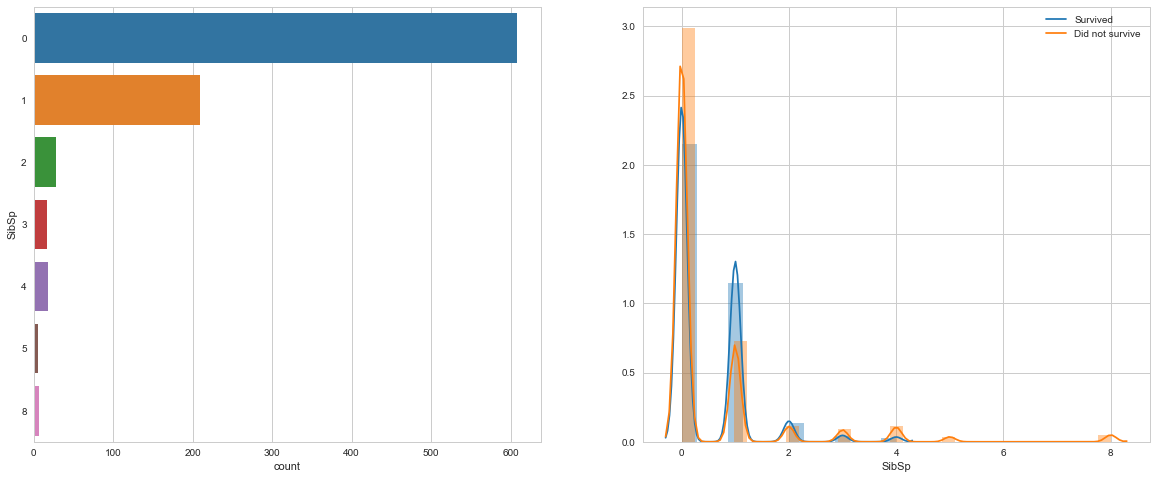

In [161]:
plot_count_dist(data= training_data , 
                dis_df= df_dis, 
                label_column= 'Survived', 
                target_column= 'SibSp', 
                figsize=(20, 8))

It's interesting to see that the passengers with one or two spouses or siblings had more survivors than deaths.

### Feature: Parch

Description: The number of parents/children the passenger has aboard the Titanic.

In [162]:
training_data.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [163]:
training_data.Parch.isnull().sum()

0

There are no missing values in the column. We can also see that there is a limited number of unique values. There is no outlier neither. 

We can add this field to our subset dataframes.

In [164]:
df_con['Parch'] = training_data['Parch']
df_dis['Parch'] = training_data['Parch']

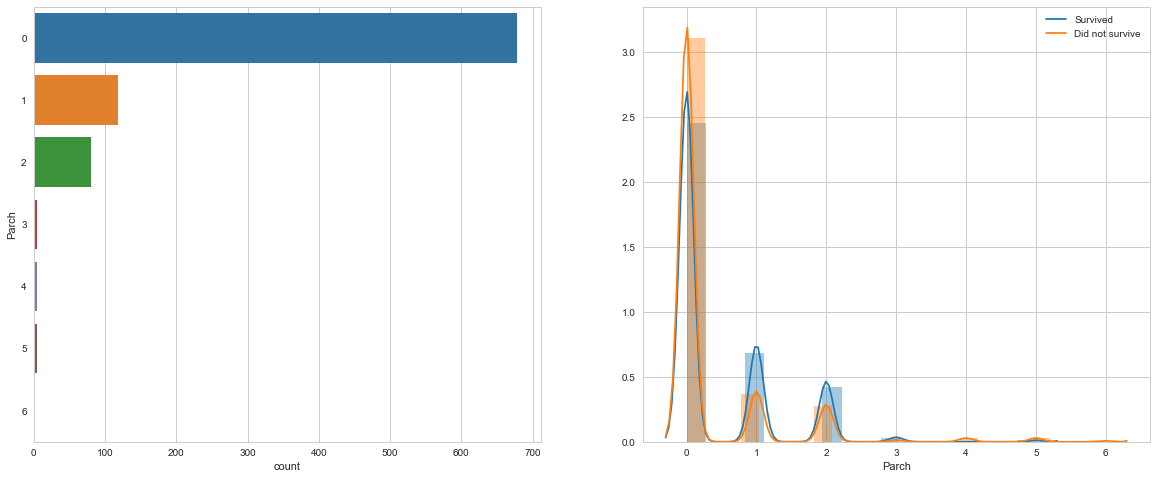

In [165]:
plot_count_dist(data= training_data , 
                dis_df= df_dis, 
                label_column= 'Survived', 
                target_column= 'Parch', 
                figsize=(20, 8))

Passengers with one or two parents/children aboard have more likely to survive than others.

### Feature: Ticket

Description: The ticket number of the passenger.

In [166]:
training_data.Ticket.value_counts()

347082        7
CA. 2343      7
1601          7
CA 2144       6
3101295       6
             ..
113510        1
347087        1
349216        1
C.A. 34260    1
349240        1
Name: Ticket, Length: 681, dtype: int64

In [168]:
print("There are {} unique Ticket values.".format(len(training_data.Ticket.unique())))

There are 681 unique Ticket values.


In [167]:
training_data.Ticket.isnull().sum()

0

From the unique values, we can observe that some are repeating. At first glance, it seems hard to find patterns in structure of ticket numbers.

Although there are no missing values, we won't add this field to our subset dataframes as there are too many unique ticket values to take advantage of this field for now.

**Challenge #2 :** how to reduce the number of unique ticket features ?

### Feature: Fare

Description: the fare paid by the passenger.

In [201]:
training_data.Fare.value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
8.4583      1
9.8375      1
8.3625      1
14.1083     1
17.4000     1
Name: Fare, Length: 248, dtype: int64

In [202]:
print("There are {} unique Fare values.".format(len(training_data.Fare.unique())))

There are 248 unique Fare values.


In [203]:
print("There are {} missing Fare values.".format(missing_vals['Fare']))

There are 0 (0.0%) missing Fare values.


Because Fare is a float (number) let's add it as it is to our continuous sub dataframe but to add it to our categorical sub dataframe, we'll cut it into bins.

In [221]:
df_con['Fare'] = training_data['Fare'] 
df_dis['Fare'] = pd.cut(training_data['Fare'], bins=5)

In [222]:
df_dis.Fare.value_counts()

(-0.512, 102.466]     836
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

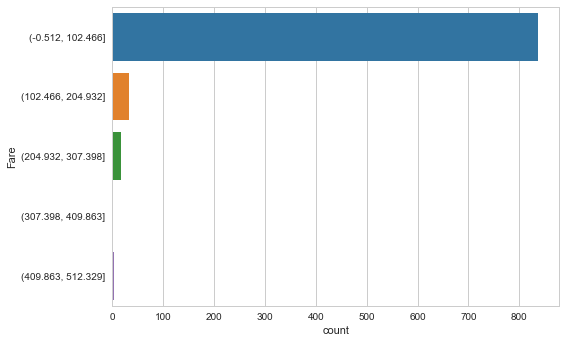

In [231]:
sns.countplot(y='Fare', data=df_dis)

**Challenge #3:** How would you change the Fare bins?

### Feature: Cabin

Description: The cabin number of the passenger.

In [169]:
training_data.Cabin.value_counts()

B96 B98        4
C23 C25 C27    4
G6             4
D              3
F33            3
              ..
C95            1
E17            1
C111           1
C99            1
C91            1
Name: Cabin, Length: 147, dtype: int64

In [175]:
print("There are {} unique Ticket values.".format(len(training_data.Ticket.unique())))

There are 681 unique Ticket values.


In [174]:
print("There are {} missing Cabin values.".format(missing_vals['Cabin']))

There are 687 (77.1%) missing Cabin values.


Since there are too many missing values, we won't use Cabin for our initial models and won't add it to our sub dataframes.

### Feature: Embarked

Description: the port in which the passenger embarked.

In [178]:
training_data.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

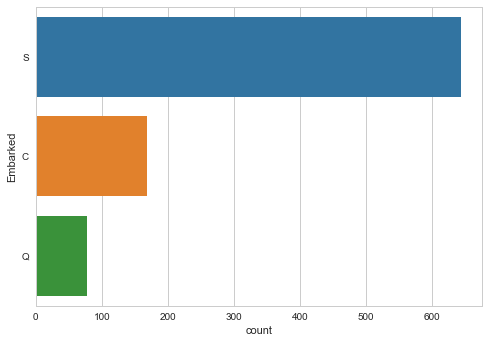

In [200]:
sns.countplot(y='Embarked', data=training_data)

In [180]:
print("There are {} missing Embarked values.".format(missing_vals['Embarked']))

There are 2 (0.22%) missing Embarked values.


There are only 2 missing values in the column. This is very low regarding the total number of rows. We can also see that there are only 3 unique values. There is no outlier neither. 

We'll remove the two rows with missing values for Embarked before adding Embarked to our sub dataframes.

In [193]:
df_dis['Embarked'] = training_data['Embarked']
df_con['Embarked'] = training_data['Embarked']

df_con = df_con.dropna(subset=['Embarked'])
df_dis = df_dis.dropna(subset=['Embarked'])

## Feature Encoding

We can’t have text in our data if we’re going to run any kind of model on it. So before we can run a model, we need to make this data ready for the model.

Feature encoding is the process of turning categorical data in a dataset into numerical data. It is essential that we perform feature encoding because most machine learning models can only interpret numerical data and not data in text form.

We will do apply this data processing technique to both our subset dataframes.

In [269]:
# One hot encode discrete dataframe
one_hot_cols = df_dis.columns.tolist()
one_hot_cols.remove('Survived')
df_dis_enc = pd.get_dummies(df_dis, columns=one_hot_cols)

df_dis_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,...,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]"
0,0,0,0,1,1,0,0,1,0,0,...,0,0,0,0,1,1,0,0,0,0
1,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
2,1,0,0,1,0,1,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,1,1,0,0,0,1,0,1,0,0,...,0,0,0,0,1,1,0,0,0,0
4,0,0,0,1,1,0,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [272]:
# One hot encode the categorical columns
df_embarked_one_hot = pd.get_dummies(df_con['Embarked'], 
                                     prefix='embarked')

df_sex_one_hot = pd.get_dummies(df_con['Sex'], 
                                prefix='sex')

df_plcass_one_hot = pd.get_dummies(df_con['Pclass'], 
                                   prefix='pclass')

In [273]:
# Combine the one hot encoded columns with df_con_enc
df_con_enc = pd.concat([df_con, 
                        df_embarked_one_hot, 
                        df_sex_one_hot, 
                        df_plcass_one_hot], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

In [274]:
df_con_enc.head()

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,0,8.0500,0,0,1,0,1,0,0,1


## Build Machine Learning Models

Now that we have finalised the preprocessing step, we can run models on it to predict which passengers survived.

We will start by using the continuous encoded dataframe to make our predictions.

In [275]:
selected_df = df_con_enc

### Data separation

In [291]:
X_train = selected_df.drop("Survived", axis = 1) #data
y_train = selected_df.Survived #label

### Function to fit Machine Learning Algorithms

In the context of this project, we are facing a classification problem. 

We will apply the following algorithms to our training data and see which one yields the best results : 
- Logistic Regression
- Support Vector Machine
- Decision Tree Classifier
- K-Nearest-Neighbours

As we will be using sklearn library only, we will write a function to standardise the execution of models and printing accuracy scores. The function will first estimate the parameters for the Machine Learning algorithm (training), then it will evaluate how well the method worked (testing).

In [283]:
def fit_ml_algo(algo, X_train, y_train, cv):
    """
    Function that runs the requested algorithm and returns the accuracy metrics.
        Parameters
            algo: the name of the algorithm we will run from sklearn library
            X_train: the input data of the model
            y_train: the real values of the target feature from training dataset
            cv: k-fold cross validation, the number of blocks in which we divide our data
            n_jobs: number of CPU cores used during cross validation loop (-1 means using all processors)
        Return
            acc: model accuracy score
            acc_cv: the adjusted accuracy score after k-fold cross validation
    
    """
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

### Logistic Regression

In [292]:
# Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 79.98
Accuracy CV 10-Fold: 79.42
Running Time: 0:00:05.142813


### Support Vector Machine

In [294]:
# Linear SVC
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 78.29
Accuracy CV 10-Fold: 74.69
Running Time: 0:00:00.267834


### K-Nearest-Neighbours

In [293]:
# k-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 83.46
Accuracy CV 10-Fold: 76.72
Running Time: 0:00:02.676933


### Decision Tree Classifier

In [295]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 92.46
Accuracy CV 10-Fold: 80.2
Running Time: 0:00:00.075957


### Model results

In [323]:
model.feature_importances_

array([0.05467504, 0.06595232, 0.35809838, 0.01564486, 0.01007519,
       0.01802213, 0.        , 0.37856713, 0.        , 0.00368262,
       0.09528233])

Here we will be looking at the cross-validation accuracy score to pick the most performant model, as the standard .fit() method can randomly score higher than usual.

In [296]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression',
              'Linear SVC', 'Decision Tree'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_linear_svc, 
        acc_cv_dt,
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
3,Decision Tree,80.20
1,Logistic Regression,79.42
0,KNN,76.72
2,Linear SVC,74.69


Because the Decision Tree algorithm provides the best results, we will use it for the next steps.

In [380]:
model_dt = DecisionTreeClassifier().fit(X_train, y_train)

**Challenge #4:** how to improve the decision tree model ?

### Feature importance

Which features of the best model were most important for making predictions?

In [352]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
        model: the model to use
        data: the input dataset
    """
    model.fit(X_train, y_train)
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp

,imp,col
7,0.000000,sex_male
8,0.000439,pclass_1
9,0.004816,pclass_2
4,0.010025,embarked_Q
3,0.010050,embarked_C
5,0.017460,embarked_S
0,0.051267,SibSp
1,0.062463,Parch
10,0.096478,pclass_3
2,0.368435,Fare


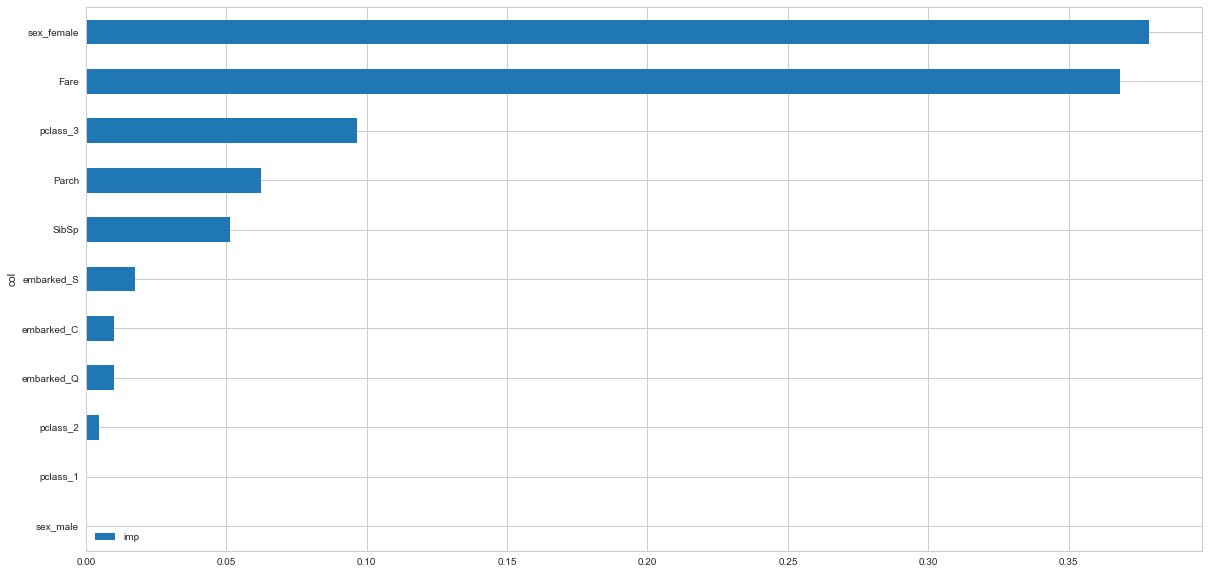

In [353]:
feature_importance(DecisionTreeClassifier(), X_train)

What we can get out of this feature importance plot is that we can certainly remove certain features from our model as they don't contribute anough to the prediction.

We are also missing some features such as name and age which might provide important information as well.

In the next iteration, we will remove the features that contributed the least to our model and see if we end up with more precision in our predictions.

## Submission

We will use the model with the highest cross validation accuracy score to make a prediction on the test dataset and then submit our predictions to Kaggle.

We want to make predictions on the same kind of columnns our model is trained on.

So we have to select the subset of right columns of the test dateframe, encode them and make a prediciton with our model.

In [372]:
# The test dataframe should have the same structure as the one below
X_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [373]:
# Here is how our test dataframe looks like
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [374]:
# One hot encode the columns like we did in the X_train dataframe
test_embarked_one_hot = pd.get_dummies(test_data['Embarked'], 
                                     prefix='embarked')

test_sex_one_hot = pd.get_dummies(test_data['Sex'], 
                                prefix='sex')

test_plcass_one_hot = pd.get_dummies(test_data['Pclass'], 
                                   prefix='pclass')

In [375]:
# Combine test dataframe with one hot encoded columns
test = pd.concat([test_data, 
                  test_embarked_one_hot, 
                  test_sex_one_hot, 
                  test_plcass_one_hot], axis=1)

In [387]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
count,418.000000,418.000000,332.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188,0.244019,0.110048,0.645933,0.363636,0.636364,0.255981,0.222488,0.521531
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.840500,0.430019,0.313324,0.478803,0.481622,0.481622,0.436934,0.416416,0.500135
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We need to fix the missing value in the Fare column before executing the model. We will replace the null value by the average Fare price paid by passengers.

In [386]:
test['Fare'] = test.Fare.replace(np.NaN, test.Fare.mean()) 

In [388]:
# Create a list of columns to be used for the predictions
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['SibSp', 'Parch', 'Fare', 'embarked_C', 'embarked_Q', 'embarked_S',
       'sex_female', 'sex_male', 'pclass_1', 'pclass_2', 'pclass_3'],
      dtype='object')

In [389]:
# Run our model on test data (unseen data on which the model hasn't been trained on)
predictions = model_dt.predict(test[wanted_test_columns])

In [392]:
# first 10 outcomes predicted by our model
predictions[:10]

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 0])

In [394]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [397]:
submission.dtypes

PassengerId    int64
Survived       int64
dtype: object

In [399]:
# Are our test and submission dataframes the same length?
if len(submission) == len(test_data):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [402]:
# Convert submisison dataframe to csv for submission to csv for Kaggle submisison
submission.to_csv('decision_tree_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!
